<a href="https://colab.research.google.com/github/mckang6113875/AP_Test_OPEN/blob/main/SVM_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#6113875

In [ ]:
! git clone https://github.com/mckang6113875/AP_Test_OPEN.git

Cloning into 'AP_Test_OPEN'...
remote: Enumerating objects: 538, done.
remote: Counting objects: 100% (119/119), done.
remote: Compressing objects: 100% (92/92), done.
remote: Total 538 (delta 64), reused 63 (delta 27), pack-reused 419
Receiving objects: 100% (538/538), 241.97 MiB | 12.34 MiB/s, done.
Resolving deltas: 100% (338/338), done.


(720, 1140, 3)


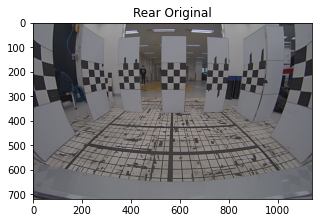

In [4]:
import cv2
import matplotlib.pyplot as plt
#original = cv2.imread('/content/AP_Test_OPEN/RS4_F_1.png')
#original = cv2.imread('/content/AP_Test_OPEN/SX2_R_1.bmp')
original = cv2.imread('/content/AP_Test_OPEN/ViewMode_R.bmp')
#original = cv2.imread('/content/AP_Test_OPEN/Test_5.bmp')
#original = cv2.imread('/content/AP_Test_OPEN/ViewMode_R_fisheye.bmp')
#original = cv2.imread('/content/AP_Test_OPEN/Paper_Before.bmp')

original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)

#img = cv2.imread('/content/AP_Test_OPEN/RS4_F_1.png')
#img = cv2.imread('/content/AP_Test_OPEN/SX2_R_1.bmp')
img = cv2.imread('/content/AP_Test_OPEN/ViewMode_R.bmp')
#img = cv2.imread('/content/AP_Test_OPEN/Test_5.bmp')
#img = cv2.imread('/content/AP_Test_OPEN/ViewMode_R_fisheye.bmp')
#img = cv2.imread('/content/AP_Test_OPEN/Paper_Before.bmp')

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

fig = plt.figure(figsize=(5, 5))
plt.imshow(original)
plt.title('Rear Original')
#plt.grid(color='white', linestyle='--', linewidth=1)
#plt.xticks(np.arange(0, original.shape[1], 50));
#plt.yticks(np.arange(0, original.shape[0], 50));
print(original.shape)

## Only CV2 Function
- getOptimalNewCameraMatrix
- undistort

True
(720, 1140, 3)
[[ 35.16669961   0.         569.99999975]
 [  0.         758.33547005 359.99999955]
 [  0.           0.           1.        ]]
[[ 42.36646461   0.         571.87857487]
 [  0.         836.21002197 360.42972484]
 [  0.           0.           1.        ]]


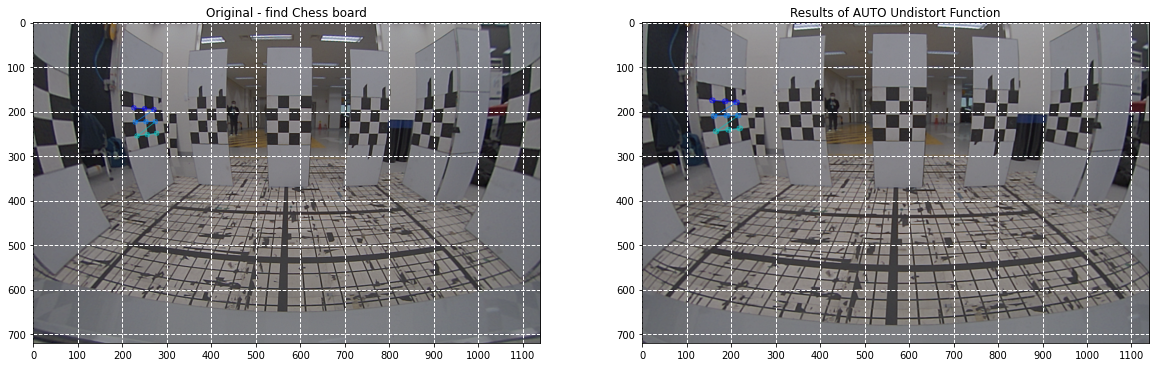

In [ ]:
import numpy as np
import cv2

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
wc = 3
hc = 3

objp = np.zeros((wc*hc,3), np.float32)
objp[:, :2] = np.mgrid[0:wc, 0:hc].T.reshape(-1,2)

objpoints = []
imgpoints = []

img1 = cv2.resize(img, dsize = (img.shape[1], img.shape[0]), interpolation = cv2.INTER_AREA)
gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

ret, corners = cv2.findChessboardCorners(gray, (wc, hc), None)
print(ret)

if ret == True: #True
  objpoints.append(objp)
  corners2 = cv2.cornerSubPix(gray, corners, (10,10), (-1, -1), criteria) #10, 10
  imgpoints.append(corners2)

  img2 = cv2.drawChessboardCorners(img1, (wc, hc), corners2, ret)

  ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
  h, w = img2.shape[:2]
  newcameramtx2, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w, h), 0.5) #0.5

  img3 = cv2.undistort(img2, mtx, dist)
  img4= cv2.undistort(img2, mtx, dist, None, newcameramtx2)

  fig = plt.figure(figsize=(20, 10))
  plt.subplot(121)
  plt.imshow(img2)
  plt.title('Original - find Chess board')
  plt.grid(color='white', linestyle='--', linewidth=1)
  plt.xticks(np.arange(0, img2.shape[1], 100))
  plt.yticks(np.arange(0, img2.shape[0], 100))
  plt.subplot(122)
  plt.imshow(img4)
  plt.title('Results of AUTO Undistort Function')
  plt.grid(color='white', linestyle='--', linewidth=1)
  plt.xticks(np.arange(0, img4.shape[1], 100))
  plt.yticks(np.arange(0, img4.shape[0], 100))

print(img2.shape)
print(mtx)
print(newcameramtx2)

mtx_SX2 = mtx;
#print(mtx_SX2);

True
[[ 40.94403248   0.         569.99993318]
 [  0.         655.73009525 360.0000464 ]
 [  0.           0.           1.        ]]
[[5.81711807e+01 0.00000000e+00 6.14797198e+02]
 [0.00000000e+00 1.05568936e+03 3.72052756e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


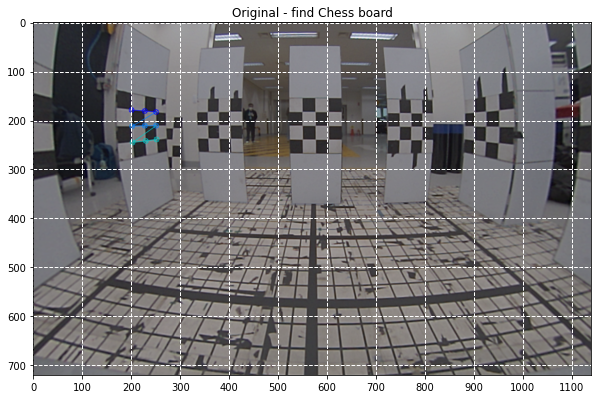

In [ ]:
# find good mtx1

good = cv2.imread('/content/AP_Test_OPEN/Paper_ref3.bmp')
good = cv2.cvtColor(good, cv2.COLOR_BGR2RGB)

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
wc = 3
hc = 3

objp = np.zeros((wc*hc,3), np.float32)
objp[:, :2] = np.mgrid[0:wc, 0:hc].T.reshape(-1,2)

objpoints = []
imgpoints = []

good = cv2.resize(good, dsize = (good.shape[1], good.shape[0]), interpolation = cv2.INTER_AREA)
gray = cv2.cvtColor(good, cv2.COLOR_BGR2GRAY)

ret, corners = cv2.findChessboardCorners(gray, (wc, hc), None)
print(ret)

if ret == True:
  objpoints.append(objp)
  corners2 = cv2.cornerSubPix(gray, corners, (10,10), (-1, -1), criteria)
  imgpoints.append(corners2)

  good = cv2.drawChessboardCorners(good, (wc, hc), corners2, ret)

  ret, mtx1, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
  h, w = good.shape[:2]
  newcameramtx3, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w, h), 0.5) #0 default

  better= cv2.undistort(good, mtx1, dist, None, newcameramtx3)

  fig = plt.figure(figsize=(10, 10))
  #plt.subplot(121)
  plt.imshow(good)
  plt.title('Original - find Chess board')
  plt.grid(color='white', linestyle='--', linewidth=1)
  plt.xticks(np.arange(0, img2.shape[1], 100))
  plt.yticks(np.arange(0, img2.shape[0], 100))
  #plt.subplot(122)
  #plt.imshow(better)
  #plt.title('Results of AUTO Undistort Function')
  #plt.grid(color='white', linestyle='--', linewidth=1)
  #plt.xticks(np.arange(0, img4.shape[1], 100))
  #plt.yticks(np.arange(0, img4.shape[0], 100))

print(mtx1);
print(newcameramtx3);

[[0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0.]]
[[ 35.16669961   0.         569.99999975]
 [  0.         758.33547005 359.99999955]
 [  0.           0.           1.        ]]
[[ 42.36646461   0.         571.87857487]
 [  0.         836.21002197 360.42972484]
 [  0.           0.           1.        ]]
[[ 40.94403248   0.         569.99993318]
 [  0.         655.73009525 360.0000464 ]
 [  0.           0.           1.        ]]


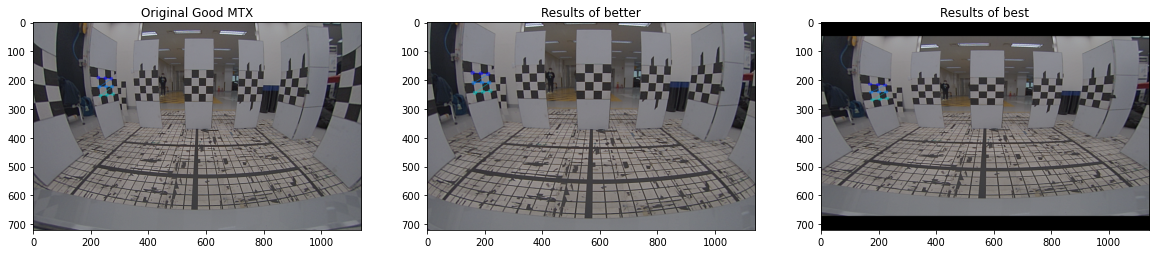

In [ ]:
dist0 = dist
dist0[:1] = 0

best= cv2.undistort(img2, mtx, dist0, None, mtx1)
#best= cv2.undistort(img4, newcameramtx2, dist0, None, mtx1)

fig = plt.figure(figsize=(20, 10))
plt.subplot(131)
plt.imshow(img2)
plt.title('Original Good MTX')
#plt.grid(color='white', linestyle='--', linewidth=1)
#plt.xticks(np.arange(0, img2.shape[1], 100))
#plt.yticks(np.arange(0, img2.shape[0], 100))
plt.subplot(132)
plt.imshow(img4)
plt.title('Results of better')
#plt.grid(color='white', linestyle='--', linewidth=1)
#plt.xticks(np.arange(0, img4.shape[1], 100))
#plt.yticks(np.arange(0, img4.shape[0], 100))
plt.subplot(133)
plt.imshow(best)
plt.title('Results of best')

print(dist0);
print(dist);
print(mtx)
print(newcameramtx2)
print(mtx1)

# 220704

In [1]:
! git clone https://github.com/mckang6113875/AP_Test_OPEN.git

Cloning into 'AP_Test_OPEN'...
remote: Enumerating objects: 547, done.
remote: Counting objects: 100% (128/128), done.
remote: Compressing objects: 100% (101/101), done.
remote: Total 547 (delta 71), reused 63 (delta 27), pack-reused 419
Receiving objects: 100% (547/547), 244.48 MiB | 24.22 MiB/s, done.
Resolving deltas: 100% (345/345), done.


(944, 1280, 3)


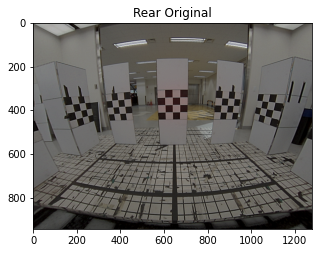

In [ ]:
import cv2
import matplotlib.pyplot as plt

original = cv2.imread('/content/AP_Test_OPEN/CE1_2.bmp')
original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)

img = cv2.imread('/content/AP_Test_OPEN/CE1_2.bmp')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

fig = plt.figure(figsize=(5, 5))
plt.imshow(original)
plt.title('Rear Original')
#plt.grid(color='white', linestyle='--', linewidth=1)
#plt.xticks(np.arange(0, original.shape[1], 50));
#plt.yticks(np.arange(0, original.shape[0], 50));
print(original.shape)

True
[[ 11.5173063    0.         640.        ]
 [  0.         198.76611031 472.        ]
 [  0.           0.           1.        ]]


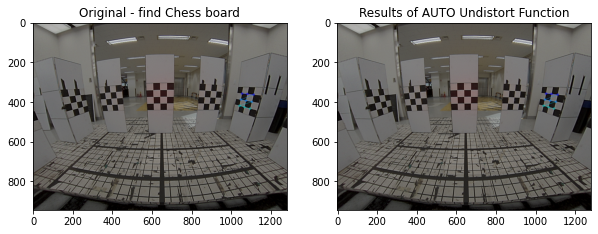

In [ ]:
import numpy as np
import cv2

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
wc = 3
hc = 3

objp = np.zeros((wc*hc,3), np.float32)
objp[:, :2] = np.mgrid[0:wc, 0:hc].T.reshape(-1,2)

objpoints = []
imgpoints = []

img1 = cv2.resize(img, dsize = (img.shape[1], img.shape[0]), interpolation = cv2.INTER_AREA)
gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

ret, corners = cv2.findChessboardCorners(gray, (wc, hc), None)
print(ret)

if ret == True: #True
  objpoints.append(objp)
  corners2 = cv2.cornerSubPix(gray, corners, (10,10), (-1, -1), criteria) #10, 10
  imgpoints.append(corners2)

  img2 = cv2.drawChessboardCorners(img1, (wc, hc), corners2, ret)

  ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
  h, w = img2.shape[:2]
  newcameramtx2, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w, h), 0.5) #0.5

  img3 = cv2.undistort(img2, mtx, dist)
  img4= cv2.undistort(img2, mtx, dist, None, newcameramtx2)

  fig = plt.figure(figsize=(10, 10))
  plt.subplot(121)
  plt.imshow(img2)
  plt.title('Original - find Chess board')
  #plt.grid(color='white', linestyle='--', linewidth=1)
  #plt.xticks(np.arange(0, img2.shape[1], 100))
  #plt.yticks(np.arange(0, img2.shape[0], 100))
  plt.subplot(122)
  plt.imshow(img4)
  plt.title('Results of AUTO Undistort Function')
  #plt.grid(color='white', linestyle='--', linewidth=1)
  #plt.xticks(np.arange(0, img4.shape[1], 100))
  #plt.yticks(np.arange(0, img4.shape[0], 100))

#print(img2.shape)
print(mtx)
#print(newcameramtx2)

#mtx_SX2 = mtx;
#print(mtx_SX2);

(768, 1024, 3)


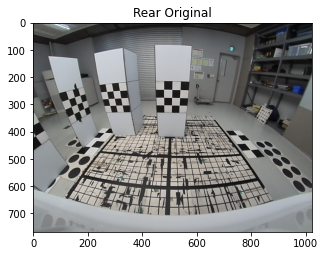

In [ ]:
import cv2
import matplotlib.pyplot as plt

original = cv2.imread('/content/AP_Test_OPEN/NX4_2.bmp')
original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)

img = cv2.imread('/content/AP_Test_OPEN/NX4_2.bmp')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

fig = plt.figure(figsize=(5, 5))
plt.imshow(original)
plt.title('Rear Original')
#plt.grid(color='white', linestyle='--', linewidth=1)
#plt.xticks(np.arange(0, original.shape[1], 50));
#plt.yticks(np.arange(0, original.shape[0], 50));
print(original.shape)

True
[[  6.80180907   0.         512.        ]
 [  0.         417.60113286 384.        ]
 [  0.           0.           1.        ]]


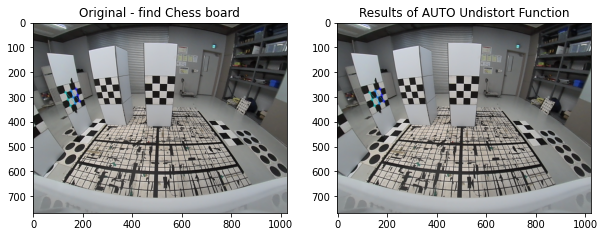

In [ ]:
import numpy as np
import cv2

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
wc = 3
hc = 3

objp = np.zeros((wc*hc,3), np.float32)
objp[:, :2] = np.mgrid[0:wc, 0:hc].T.reshape(-1,2)

objpoints = []
imgpoints = []

img1 = cv2.resize(img, dsize = (img.shape[1], img.shape[0]), interpolation = cv2.INTER_AREA)
gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

ret, corners = cv2.findChessboardCorners(gray, (wc, hc), None)
print(ret)

if ret == True: #True
  objpoints.append(objp)
  corners2 = cv2.cornerSubPix(gray, corners, (10,10), (-1, -1), criteria) #10, 10
  imgpoints.append(corners2)

  img2 = cv2.drawChessboardCorners(img1, (wc, hc), corners2, ret)

  ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
  h, w = img2.shape[:2]
  newcameramtx2, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w, h), 0.5) #0.5

  img3 = cv2.undistort(img2, mtx, dist)
  img4= cv2.undistort(img2, mtx, dist, None, newcameramtx2)

  fig = plt.figure(figsize=(10, 10))
  plt.subplot(121)
  plt.imshow(img2)
  plt.title('Original - find Chess board')
  #plt.grid(color='white', linestyle='--', linewidth=1)
  #plt.xticks(np.arange(0, img2.shape[1], 100))
  #plt.yticks(np.arange(0, img2.shape[0], 100))
  plt.subplot(122)
  plt.imshow(img4)
  plt.title('Results of AUTO Undistort Function')
  #plt.grid(color='white', linestyle='--', linewidth=1)
  #plt.xticks(np.arange(0, img4.shape[1], 100))
  #plt.yticks(np.arange(0, img4.shape[0], 100))

#print(img2.shape)
print(mtx)
#print(newcameramtx2)

#mtx_SX2 = mtx;
#print(mtx_SX2);

(720, 1140, 3)


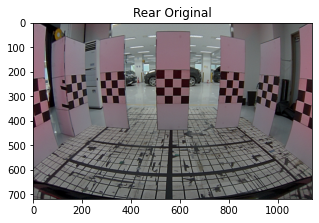

In [ ]:
import cv2
import matplotlib.pyplot as plt

original = cv2.imread('/content/AP_Test_OPEN/RS4_1.bmp')
original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)

img = cv2.imread('/content/AP_Test_OPEN/RS4_1.bmp')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

fig = plt.figure(figsize=(5, 5))
plt.imshow(original)
plt.title('Rear Original')
#plt.grid(color='white', linestyle='--', linewidth=1)
#plt.xticks(np.arange(0, original.shape[1], 50));
#plt.yticks(np.arange(0, original.shape[0], 50));
print(original.shape)

True
[[375.40697629   0.         564.00996451]
 [  0.         384.10299046 361.38306014]
 [  0.           0.           1.        ]]


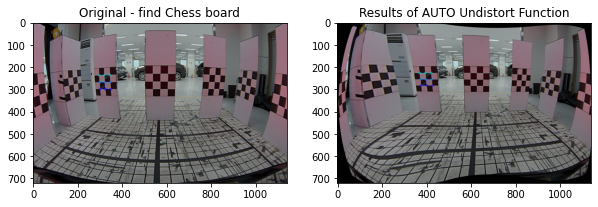

In [ ]:
import numpy as np
import cv2

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
wc = 3
hc = 3

objp = np.zeros((wc*hc,3), np.float32)
objp[:, :2] = np.mgrid[0:wc, 0:hc].T.reshape(-1,2)

objpoints = []
imgpoints = []

img1 = cv2.resize(img, dsize = (img.shape[1], img.shape[0]), interpolation = cv2.INTER_AREA)
gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

ret, corners = cv2.findChessboardCorners(gray, (wc, hc), None)
print(ret)

if ret == True: #True
  objpoints.append(objp)
  corners2 = cv2.cornerSubPix(gray, corners, (10,10), (-1, -1), criteria) #10, 10
  imgpoints.append(corners2)

  img2 = cv2.drawChessboardCorners(img1, (wc, hc), corners2, ret)

  ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
  h, w = img2.shape[:2]
  newcameramtx2, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w, h), 0.5) #0.5

  img3 = cv2.undistort(img2, mtx, dist)
  img4= cv2.undistort(img2, mtx, dist, None, newcameramtx2)

  fig = plt.figure(figsize=(10, 10))
  plt.subplot(121)
  plt.imshow(img2)
  plt.title('Original - find Chess board')
  #plt.grid(color='white', linestyle='--', linewidth=1)
  #plt.xticks(np.arange(0, img2.shape[1], 100))
  #plt.yticks(np.arange(0, img2.shape[0], 100))
  plt.subplot(122)
  plt.imshow(img4)
  plt.title('Results of AUTO Undistort Function')
  #plt.grid(color='white', linestyle='--', linewidth=1)
  #plt.xticks(np.arange(0, img4.shape[1], 100))
  #plt.yticks(np.arange(0, img4.shape[0], 100))

#print(img2.shape)
print(mtx)
#print(newcameramtx2)

#mtx_SX2 = mtx;
#print(mtx_SX2);

(720, 1140, 3)


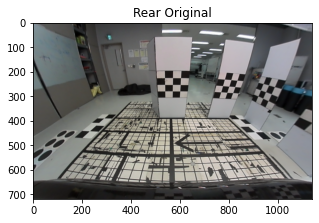

In [ ]:
import cv2
import matplotlib.pyplot as plt

original = cv2.imread('/content/AP_Test_OPEN/tmp.bmp')
original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)

img = cv2.imread('/content/AP_Test_OPEN/tmp.bmp')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

fig = plt.figure(figsize=(5, 5))
plt.imshow(original)
plt.title('Rear Original')
#plt.grid(color='white', linestyle='--', linewidth=1)
#plt.xticks(np.arange(0, original.shape[1], 50));
#plt.yticks(np.arange(0, original.shape[0], 50));
print(original.shape)

In [ ]:
import numpy as np
import cv2

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
wc = 3
hc = 3

objp = np.zeros((wc*hc,3), np.float32)
objp[:, :2] = np.mgrid[0:wc, 0:hc].T.reshape(-1,2)

objpoints = []
imgpoints = []

img1 = cv2.resize(img, dsize = (img.shape[1], img.shape[0]), interpolation = cv2.INTER_AREA)
gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

ret, corners = cv2.findChessboardCorners(gray, (wc, hc), None)
print(ret)

if ret == True: #True
  objpoints.append(objp)
  corners2 = cv2.cornerSubPix(gray, corners, (10,10), (-1, -1), criteria) #10, 10
  imgpoints.append(corners2)

  img2 = cv2.drawChessboardCorners(img1, (wc, hc), corners2, ret)

  ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
  h, w = img2.shape[:2]
  newcameramtx2, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w, h), 0.5) #0.5

  img3 = cv2.undistort(img2, mtx, dist)
  img4= cv2.undistort(img2, mtx, dist, None, newcameramtx2)

  fig = plt.figure(figsize=(10, 10))
  plt.subplot(121)
  plt.imshow(img2)
  plt.title('Original - find Chess board')
  #plt.grid(color='white', linestyle='--', linewidth=1)
  #plt.xticks(np.arange(0, img2.shape[1], 100))
  #plt.yticks(np.arange(0, img2.shape[0], 100))
  plt.subplot(122)
  plt.imshow(img4)
  plt.title('Results of AUTO Undistort Function')
  #plt.grid(color='white', linestyle='--', linewidth=1)
  #plt.xticks(np.arange(0, img4.shape[1], 100))
  #plt.yticks(np.arange(0, img4.shape[0], 100))

#print(img2.shape)
print(mtx)
#print(newcameramtx2)

#mtx_SX2 = mtx;
#print(mtx_SX2);

False
[[375.40697629   0.         564.00996451]
 [  0.         384.10299046 361.38306014]
 [  0.           0.           1.        ]]
